* https://cloud.google.com/vision/docs/

First enable the your API key to use Cloud Vision - will have to setup a billing account.

Follow the instructions on https://cloud.google.com/docs/authentication/getting-started to download your API key, which is a .json file.

In [1]:
#!pip3 install --upgrade google-cloud

In [2]:
#!pip install --upgrade google-cloud-vision

In [3]:
#!pip install --upgrade google-oauth

In [4]:
import io
import os
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from typing import Union, List, Set, Dict, Tuple
%matplotlib inline

# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types
from google.oauth2 import service_account

TARGET = 'person'
CONFIDENCE_THRESHOLD = 50

def format_confidence(confidence: Union[str, float]) -> float:
    """Takes a confidence from the API like 
       0.55623 and returne 55.6 (%).
    """
    return round(float(confidence) * 100, 1)

def get_objects(objects: List[types.LocalizedObjectAnnotation]) -> List[str]:
    """
    Get a list of the unique objects predicted.
    """
    labels = [obj.name.lower() for obj in objects]
    return list(set(labels))

def get_object_confidences(objects: List[types.LocalizedObjectAnnotation], target: str):
    """
    Return the list of confidences of instances of target label.
    """
    confidences = [
        format_confidence(obj.score) for obj in objects if obj.name.lower() == target
    ]
    return confidences

def get_objects_summary(objects: List[types.LocalizedObjectAnnotation]):
    """
    Get a summary of the objects detected.
    """
    objects_labels = get_objects(objects)
    return {
        target: len(get_object_confidences(objects, target))
        for target in objects_labels
    }

In [5]:
def draw_box(
    draw: ImageDraw,
    box: Tuple[float, float, float, float],
    img_width: int,
    img_height: int,
    text: str = "",
    color: Tuple[int, int, int] = (255, 255, 0),
) -> None:
    """
    Draw a bounding box on and image.
    The bounding box is defined by the tuple (y_min, x_min, y_max, x_max)
    where the coordinates are floats in the range [0.0, 1.0] and
    relative to the width and height of the image.
    For example, if an image is 100 x 200 pixels (height x width) and the bounding
    box is `(0.1, 0.2, 0.5, 0.9)`, the upper-left and bottom-right coordinates of
    the bounding box will be `(40, 10)` to `(180, 50)` (in (x,y) coordinates).
    """

    line_width = 5
    y_min, x_min, y_max, x_max = box
    (left, right, top, bottom) = (
        x_min * img_width,
        x_max * img_width,
        y_min * img_height,
        y_max * img_height,
    )
    draw.line(
        [(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
        width=line_width,
        fill=color,
    )
    if text:
        draw.text((left + line_width, abs(top - 15)), text, fill=color)

In [6]:
API_file_path = "/Users/robin/Documents/Google_API_key.json"

In [7]:
credentials = service_account.Credentials.from_service_account_file(API_file_path)
scoped_credentials = credentials.with_scopes(['https://www.googleapis.com/auth/cloud-platform'])

In [8]:
# Instantiates a client
client = vision.ImageAnnotatorClient(credentials=scoped_credentials)

Open an image file

<class 'bytes'>
<class 'numpy.ndarray'>


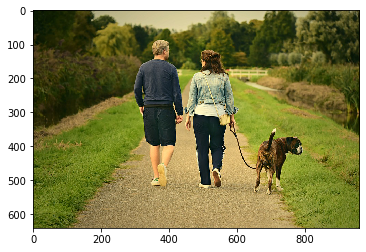

In [9]:
# The name of the image file to annotate
# file_name = 'family.jpg'
file_name = 'test-image3.jpg'

# Loads the image into memory
with io.open(file_name, 'rb') as image_file:
    content = image_file.read()
    print(type(content))


img = plt.imread(file_name)
print(type(img))
plt.imshow(img)
plt.show()

## Object

In [10]:
# help(types.Image)

In [11]:
response = client.object_localization(image=types.Image(content=content)) # Image bytes are required 

In [12]:
objects = response.localized_object_annotations

In [13]:
len(objects)

9

In [14]:
for obj in objects:
    print(obj.name.lower(), format_confidence(obj.score))

pants 92.3
shorts 91.2
dog 89.9
woman 86.5
person 84.3
person 81.7
top 74.8
top 69.6
outerwear 61.9


Some helper methods

In [15]:
get_objects(objects)

['shorts', 'outerwear', 'woman', 'pants', 'person', 'top', 'dog']

In [16]:
get_object_confidences(objects, 'person')

[84.3, 81.7]

In [17]:
get_objects_summary(objects)

{'shorts': 1,
 'outerwear': 1,
 'woman': 1,
 'pants': 1,
 'person': 2,
 'top': 2,
 'dog': 1}

## Bounding boxes

In [18]:
objects[0].bounding_poly.normalized_vertices

[x: 0.479656845331192
y: 0.44639864563941956
, x: 0.5997406840324402
y: 0.44639864563941956
, x: 0.5997406840324402
y: 0.8019291758537292
, x: 0.479656845331192
y: 0.8019291758537292
]

In [19]:
len(objects[0].bounding_poly.normalized_vertices)

4

In [20]:
def get_box(normalized_vertices : List):
    """
    Return the relative bounxing box coordinates
    defined by the tuple (y_min, x_min, y_max, x_max)
    where the coordinates are floats in the range [0.0, 1.0] and
    relative to the width and height of the image.
    """
    y = []
    x = []
    for box in normalized_vertices:
        y.append(box.y)
        x.append(box.x)
    
    box = [
        min(set(y)), 
        min(set(x)), 
        max(set(y)), 
        max(set(x))
    ]
    
    rounding_decimals = 5
    box = [round(coord, rounding_decimals) for coord in box]
    return box

In [21]:
get_box(objects[0].bounding_poly.normalized_vertices)

[0.4464, 0.47966, 0.80193, 0.59974]

In [22]:
image = Image.open(file_name)
draw = ImageDraw.Draw(image)

img_width, img_height = image.size
print(img_width)
print(img_height)

for obj in objects:
    prediction_confidence = format_confidence(obj.score)
    if obj.name.lower() == TARGET and prediction_confidence >= CONFIDENCE_THRESHOLD:
        box = get_box(obj.bounding_poly.normalized_vertices)
        draw_box(draw, box, img_width, img_height, str(prediction_confidence))

960
640


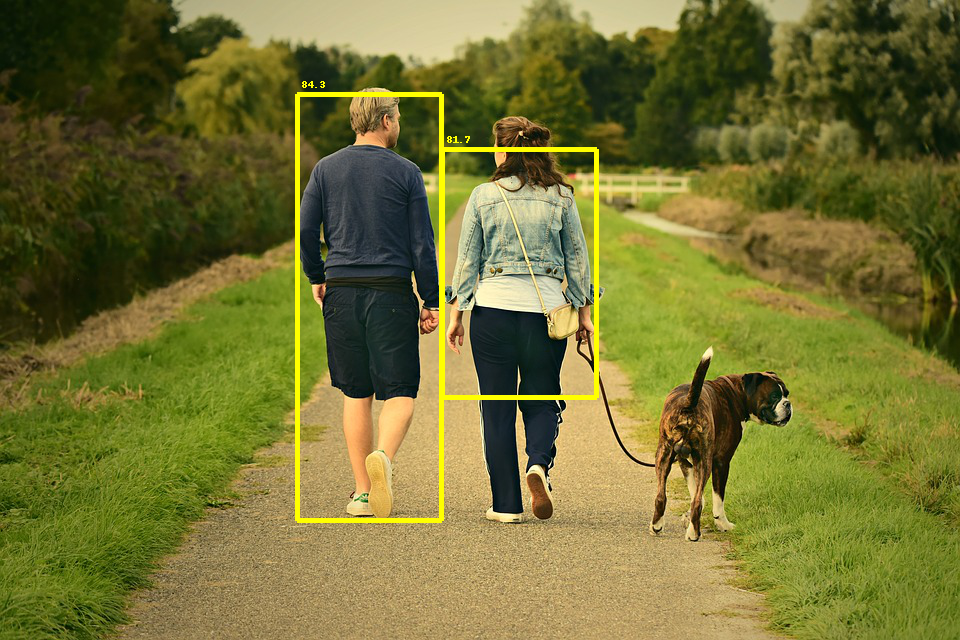

In [23]:
display(image)

## Face

In [24]:
%%time
image = types.Image(content=content)
response = client.face_detection(image=image)
faces = response.face_annotations  

CPU times: user 4.03 ms, sys: 4.02 ms, total: 8.05 ms
Wall time: 551 ms


In [25]:
len(faces)

0

In [26]:
# Names of likelihood from google.cloud.vision.enums
likelihood_name = ('UNKNOWN', 'VERY_UNLIKELY', 'UNLIKELY', 'POSSIBLE',
                       'LIKELY', 'VERY_LIKELY')

print("There are {} faces".format(len(faces)))

print('Faces:')
for face in faces:
    print('anger: {}'.format(likelihood_name[face.anger_likelihood]))
    print('joy: {}'.format(likelihood_name[face.joy_likelihood]))
    print('surprise: {}'.format(likelihood_name[face.surprise_likelihood]))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                for vertex in face.bounding_poly.vertices])

    print('face bounds: {}'.format(','.join(vertices)))

There are 0 faces
Faces:
